<a href="https://colab.research.google.com/github/TheAmirHK/Financial_projects/blob/main/ReinforcementLearning_CryptocurrencyTrading/ReinforcementLearning_Cryptocurrency_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
!pip install alpha_vantage
!pip install stable-baselines3
!pip install gym
!pip install shimmy>=2.0

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from gym import Env
from gym.spaces import Discrete, Box

from alpha_vantage.cryptocurrencies import CryptoCurrencies

In [9]:
# Fetch cryptocurrency price data from Alpha Vantage with your own API key
# well you can have youe own form https://www.alphavantage.co/support/#api-key

def fetch_crypto_data(symbol="BTC", market="USD", api_key="alpha_vantage_api_key"):
    cc = CryptoCurrencies(key=api_key, output_format="pandas")
    data, meta_data = cc.get_digital_currency_daily(symbol=symbol, market=market)

    data.reset_index(inplace=True)
    data["date"] = pd.to_datetime(data["date"])
    data.sort_values("date", inplace=True)

    data = data[["date", "1. open", "2. high", "3. low", "4. close", "5. volume"]]
    data.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

    for col in ["Open", "High", "Low", "Close", "Volume"]:
        data[col] = pd.to_numeric(data[col], errors="coerce")

    data.to_csv("bitcoin_prices.csv", index=False)

    return data

api_key = "Oops"
crypto_data = fetch_crypto_data(symbol="BTC", market="USD", api_key=api_key)

print(crypto_data.head())

          Date      Open      High       Low     Close        Volume
349 2024-02-14  49724.55  52111.00  49253.92  51858.59  20249.943697
348 2024-02-15  51858.51  52890.00  51353.49  51934.29  18465.044044
347 2024-02-16  51935.23  52608.20  51597.87  52162.64  13816.273513
346 2024-02-17  52162.65  52214.05  50642.36  51666.22   5387.348658
345 2024-02-18  51666.23  52400.00  51174.38  52153.63   3997.171439


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


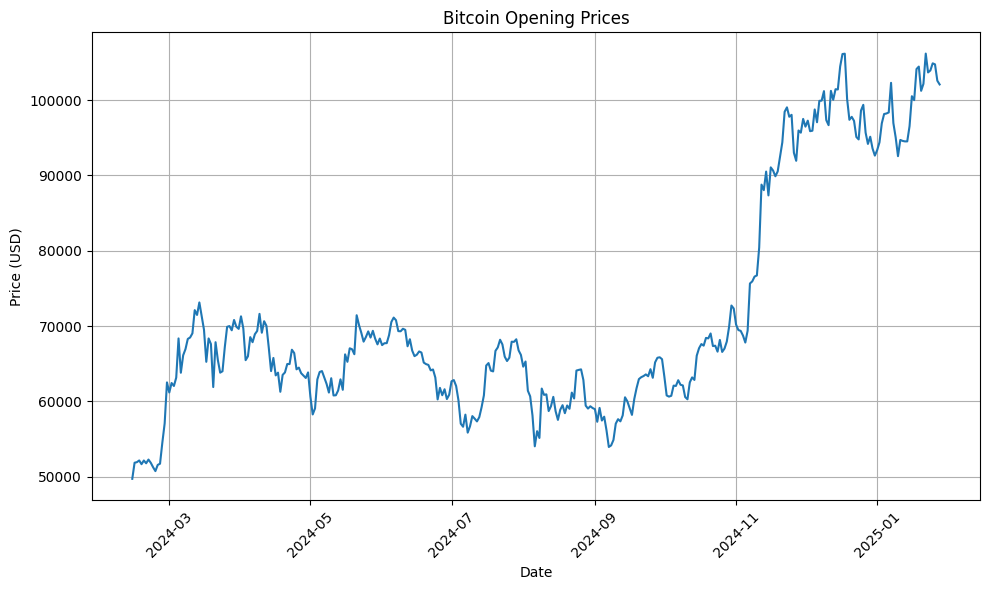

In [10]:
def plotOpening(price_data):
    plt.figure(figsize=(10, 6))
    plt.plot(price_data["Date"], price_data["Open"])
    plt.title("Bitcoin Opening Prices")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plotOpening(crypto_data)

In [11]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np

class CryptoTradingEnv(Env):
    def __init__(self, price_data):
        super(CryptoTradingEnv, self).__init__()
        self.price_data = price_data
        self.n_days = len(price_data)
        self.current_day = 0
        self.balance = 2500
        self.crypto_owned = 40
        self.initial_balance = self.balance

        # Action space: 0 = Sell, 1 = Hold, 2 = Buy
        self.action_space = Discrete(3)

        # Observation space: [Current Price, Crypto Owned, Balance]
        self.observation_space = Box(
            low=np.array([0, 0, 0]),
            high=np.array([np.inf, np.inf, np.inf]),
            dtype=np.float32
        )

    def reset(self):
        self.current_day = 0
        self.balance = 2500
        self.crypto_owned = 40
        return np.array([self.price_data["Close"].iloc[self.current_day], self.crypto_owned, self.balance])

    def step(self, action):
        current_price = self.price_data["Close"].iloc[self.current_day]

        if action == 0:  # Sell
            self.balance += self.crypto_owned * current_price
            self.crypto_owned = 0
        elif action == 2:  # Buy
            self.crypto_owned += self.balance / current_price
            self.balance = 0

        self.current_day += 1
        done = self.current_day >= self.n_days - 1

        total_assets = self.balance + self.crypto_owned * self.price_data["Close"].iloc[self.current_day]
        reward = total_assets - self.initial_balance

        obs = np.array([self.price_data["Close"].iloc[self.current_day], self.crypto_owned, self.balance])

        return obs, reward, done, {}

    def render(self):
        total_assets = self.balance + self.crypto_owned * self.price_data["Close"].iloc[self.current_day]
        print(f"Day: {self.current_day}, Balance: {self.balance:.2f}, Crypto Owned: {self.crypto_owned:.6f}, Total Assets: {total_assets:.2f}")


In [12]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

env = CryptoTradingEnv(price_data=crypto_data)

env = make_vec_env(lambda: env, n_envs=1)

model = PPO("MlpPolicy", env, verbose=1, learning_rate = 0.00003)
model.learn(total_timesteps=10000)


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 349      |
|    ep_rew_mean     | 3.06e+06 |
| time/              |          |
|    fps             | 1099     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 349       |
|    ep_rew_mean          | 3.39e+06  |
| time/                   |           |
|    fps                  | 716       |
|    iterations           | 2         |
|    time_elapsed         | 5         |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.1      |
|    explained_variance   | 1.49e-06  |
|    learning_rate        | 3e-05     |
|    loss           

In [13]:
# Test the trained RL model
test_env = CryptoTradingEnv(price_data=crypto_data)
obs = test_env.reset()

for _ in range(len(crypto_data) - 1):
    action, _ = model.predict(obs)
    obs, reward, done, info = test_env.step(action)
    test_env.render()

    if done:
        break

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Day: 1, Balance: 10000.00, Crypto Owned: 0.000000, Total Assets: 10000.00
Day: 2, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 10043.97
Day: 3, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 9948.38
Day: 4, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 10042.23
Day: 5, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 9971.65
Day: 6, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 10066.09
Day: 7, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 9984.09
Day: 8, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 9869.91
Day: 9, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 9771.40
Day: 10, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 9929.98
Day: 11, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 9960.86
Day: 12, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 10500.48
Day: 13, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 10990.25
Day: 14, Balance: 0.00, Crypto Owned: 0.192551, Total Assets: 12038.08
Day: 15, Balance: 

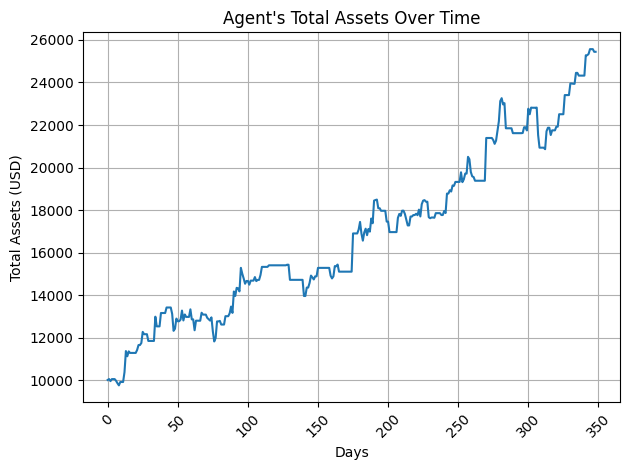

In [14]:
# Simulate trading with the trained agent to observe total assets (portfolio) at the end
def simulate_trading(env, model):
    obs = env.reset()
    total_assets_history = []

    for _ in range(len(env.price_data) - 1):
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_assets = env.balance + env.crypto_owned * env.price_data["Close"].iloc[env.current_day]
        total_assets_history.append(total_assets)
        if done:
            break

    return total_assets_history

# Plot the agent's total assets over time
assets_history = simulate_trading(test_env, model)
plt.plot(assets_history)
plt.title("Agent's Total Assets Over Time")
plt.xlabel("Days")
plt.ylabel("Total Assets (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
